**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

import os
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

**Importing Data**

In [2]:
df = pd.read_csv("day.csv")

**Data Dimensions**

In [3]:
df.shape

(730, 16)

There are 730 rows and 16 columns in the dataframe


**Cleaning the data**

In [4]:
#Drop columns with greater than 50% missing values
missing_values = round(100*(df.isnull().sum()/len(df.index)), 2)
m_val = missing_values[missing_values > 50]
len(m_val)

0

There are no missing values so we need not drop any columns.

### Data Analysis

## Determining the variables of interest

The dependent variable is the column "cnt" which is sum of the columns "casual" and "registered". So we can drop these.

In [5]:
#Drop columns "casual" and "registered", "instant", "holiday"
df.drop(columns=["instant","casual","registered", "holiday"], axis=1, inplace=True)


The numeric values associated with the labels for the variables- "season", "weathersit" and "weekday"  may indicate that there is some order to them - which is actually not the case. So they will be converted into categorical variables

In [6]:
day_dictionary = {1: 'Wed', 2: 'Thurs', 3: 'Fri', 4: 'Sat', 5: 'Sun', 6: 'Mon', 0: 'Tues'}
season_dictionary = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weather_sit_dictionary = {1:'Clear', 2:'Mist', 3:'Light Snow', 4:'Heavy Rain'}
year_dictionary={0:'2018', 1:'2019'}


Convert numerical series to categorical using a dictionary

In [7]:
df['weekday'] = df['weekday'].map(day_dictionary)
df['weathersit'] = df['weathersit'].map(weather_sit_dictionary)
df['season'] = df['season'].map(season_dictionary)
df['yr'] = df['yr'].map(year_dictionary)



In [8]:
import calendar
month_names = df['mnth'].apply(lambda x: calendar.month_abbr[x])

df['mnth'] = month_names

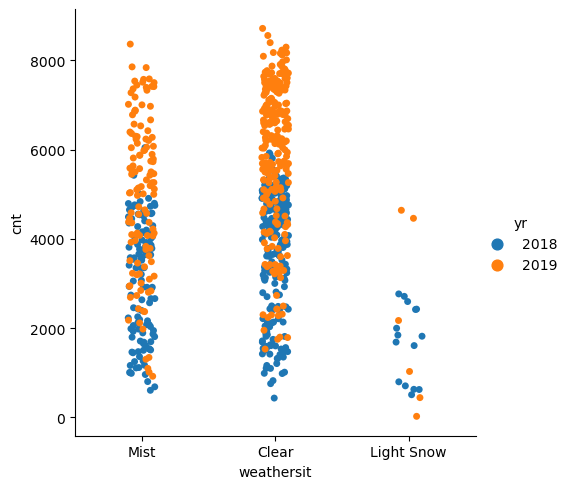

In [9]:
sns.catplot(data=df, x="weathersit", y="cnt", hue="yr")

Level of “Heavy Rain” for weathersit variable is not present in data.

In [10]:

sns.pairplot(data=df, x_vars=['temp'],y_vars=['cnt'],hue='yr',kind='reg')

The main effect of the "yr" variable is comparable to the difference in the y-intercepts. 

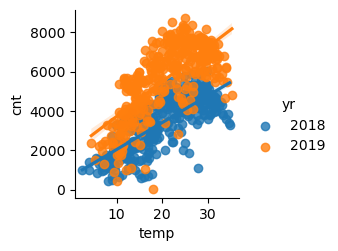

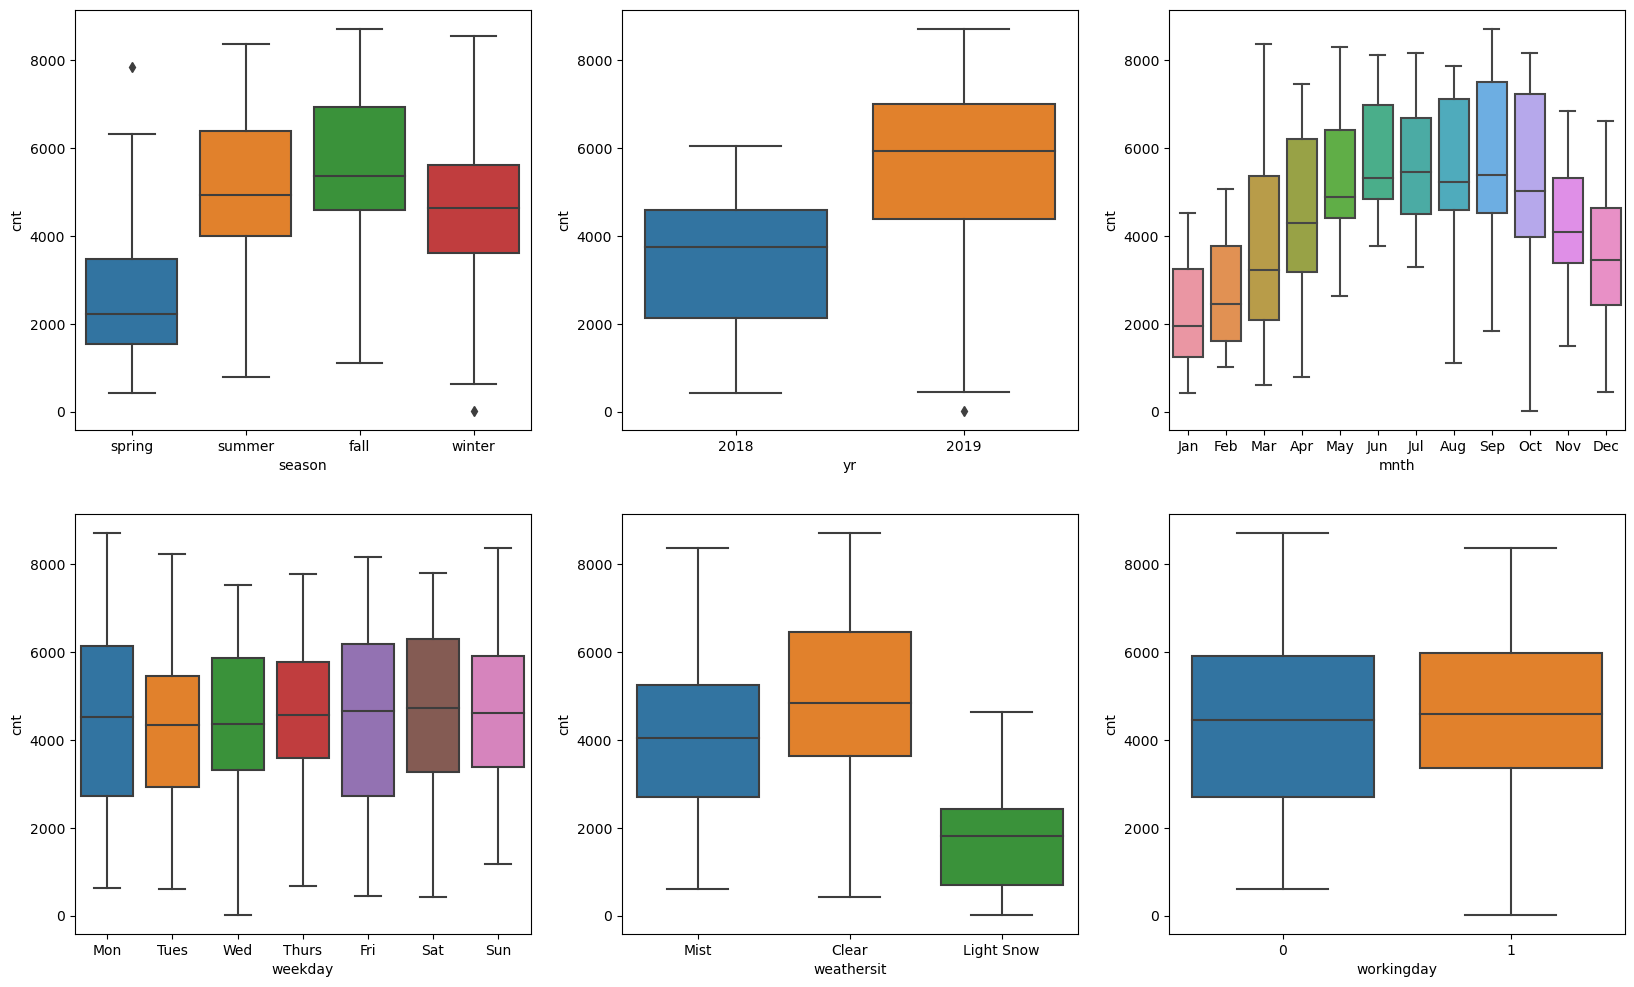

In [11]:

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df)
plt.subplot(2,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = df)
plt.subplot(2,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = df)
plt.subplot(2,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = df)
plt.subplot(2,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df)
plt.show()

In [12]:
#Remove outlier if any
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1
IQR


2796.25

In [13]:
df.shape

(730, 12)

In [14]:
df_o = df[~((df['cnt'] < (Q1 - 1.5 * IQR)) |(df['cnt'] > (Q3 + 1.5 * IQR)))]
df_o.shape

(730, 12)

## Creating dummy variables

In [15]:
cat_cols=['weekday','season','weathersit','yr','mnth']
temp_df = df[cat_cols]
dum = pd.get_dummies(temp_df,drop_first=True)
dum.shape

(730, 23)

In [16]:
dum.columns

Index(['weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thurs',
       'weekday_Tues', 'weekday_Wed', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_Light Snow', 'weathersit_Mist', 'yr_2019',
       'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep'],
      dtype='object')

In [17]:
df_processed = pd.concat([df,dum],axis=1)
df_processed.drop(cat_cols,axis=1,inplace=True)
df_processed.drop(['dteday'],axis=1,inplace=True)
#df_processed.head()

In [18]:
df_processed.head()

,workingday,temp,atemp,hum,windspeed,cnt,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,...,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep
0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,14.902598,17.68695,69.6087,16.652113,801,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [19]:
num_vars = ['temp','atemp','hum','windspeed']

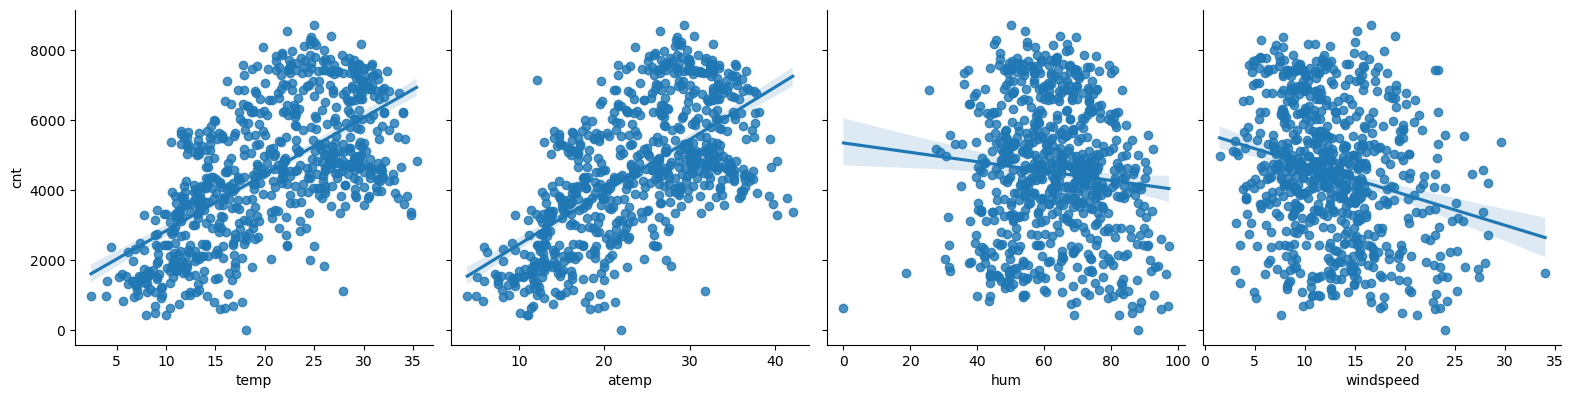

In [20]:
sns.pairplot(df_processed, x_vars=num_vars, y_vars='cnt',size=4, aspect=1,kind='reg',)
plt.show()

"temp" and "atemp" have the highest corelation with the target variable but we shall check for multicollinearity

## Multicollinearity

In [21]:
from statsmodels.stats.outliers_influence import  variance_inflation_factor

vif_data=pd.DataFrame()
vif_data['Feature'] = num_vars

vif_data['VIF'] = [variance_inflation_factor(df_processed[num_vars].values, i) \
                   for i in range(len(num_vars))]
vif_data

,Feature,VIF
0,temp,488.306256
1,atemp,542.888840
2,hum,11.071034
3,windspeed,4.678072


High VIF for  atemp indicate multicollinearity. So dropping it.

In [22]:
df_processed.drop(['atemp'],axis=1,inplace=True)

In [23]:
from statsmodels.stats.outliers_influence import  variance_inflation_factor

vif_data=pd.DataFrame()
num_vars = ['temp','hum','windspeed']
vif_data['Feature'] = num_vars

vif_data['VIF'] = [variance_inflation_factor(df_processed[num_vars].values, i) \
                   for i in range(len(num_vars))]
vif_data

,Feature,VIF
0,temp,7.132959
1,hum,9.052993
2,windspeed,4.677354


High VIF for hum indicate multicollinearity. So dropping it.

In [24]:
df_processed.drop(['hum'],axis=1,inplace=True)

### After handling multicollinearity we find the 'temp' variable has the highest correlation with 'cnt'

## Train Test Split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, = train_test_split(df_processed, test_size=0.2,random_state=100)

## Scaling the data

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [27]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars_new = ['temp','windspeed','cnt']

X_train[num_vars_new] = scaler.fit_transform(X_train[num_vars_new])

In [28]:
y_train = X_train['cnt']
X_train.drop(['cnt'],axis=1,inplace=True)

### Determining number of features

In [29]:
estimator=LinearRegression()

##### n_features_to_select use default value i.e. will be half the number of features

In [30]:
selector=RFE(estimator) # n_features_to_select default value 
selector=selector.fit(X_train,y_train)
#selector.support_

selected_features= X_train.columns[selector.support_]
X_train1 = X_train[selected_features]
X_test1 = X_test[selected_features]

## Performing Muliple linear regression

In [31]:
X_train_sm = sm.add_constant(X_train1)

In [32]:
model = sm.OLS(y_train,X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     242.4
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          2.72e-222
Time:                        15:40:49   Log-Likelihood:                 589.98
No. Observations:                 584   AIC:                            -1152.
Df Residuals:                     570   BIC:                            -1091.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2423      0.025      9.842      0.000       0.194       0.291
workingday                0.0589      0.010      5.984      0.000       0.040       0.078
temp                      0.4154      0.030     13.884      0.000       0.357       0.474
windspeed                -0.1611      0.023     -6.989      0.000      -0.206      -0.116
weekday_Mon               0.0704      0.013      5.445      0.000       0.045       0.096
season_spring            -0.1138      0.014     -7.948      0.000      -0.142      -0.086
season_winter             0.0752      0.012      6.025      0.000       0.051       0.100
weathersit_Light Snow    -0.3003      0.023    -12.967      0.000      -0.346      -0.255
weathersit_Mist          -0.0806      0.008    -10.129      0.000      -0.096      -0.065
yr_2019                   0.2325      0.007     31.269      0.000       0.218       0.247
mnth_Dec                 -0.0675      0.015     -4.371      0.000      -0.098      -0.037
mnth_Jan                 -0.0557      0.016     -3.375      0.001      -0.088      -0.023
mnth_Jul                 -0.0712      0.016     -4.534      0.000      -0.102      -0.040
mnth_Nov                 -0.0722      0.017     -4.210      0.000      -0.106      -0.039
==============================================================================
Omnibus:                      102.825   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.870
Skew:                          -0.833   Prob(JB):                     4.24e-69
Kurtosis:                       6.188   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
print(model.rsquared_adj)

0.8433540622581448


In [34]:
print(selected_features.size)

13


### Top 3 variables contributing significantly

In [35]:
# Higher t values indicate  variable is significant
print(model.tvalues.abs().sort_values(ascending = False))

yr_2019                  31.268672
temp                     13.884285
weathersit_Light Snow    12.967159
weathersit_Mist          10.128709
const                     9.841742
season_spring             7.947605
windspeed                 6.988831
season_winter             6.025122
workingday                5.984321
weekday_Mon               5.445017
mnth_Jul                  4.533924
mnth_Dec                  4.371114
mnth_Nov                  4.210022
mnth_Jan                  3.375423
dtype: float64



Top 3 variables are 'yr_2019', 'weathersit_Light Snow' and 'temp'

### Add features till adjusted R Squared increases and stop when it decreases

In [36]:

import copy

#save previous model and previous features
model_prev=copy.deepcopy(model)
prev_features = selected_features
    
# loop as long as new r_squared_adjusted is greater than previous one
while  model.rsquared_adj >= model_prev.rsquared_adj:

    #save previous model and previous features
    model_prev=copy.deepcopy(model)
    prev_features = selected_features
    X_train_sm_prev = copy.deepcopy(X_train_sm)
    
    #Select one more feature than before
    num_prev = prev_features.size
    num_features= num_prev + 1
    
    estimator=LinearRegression()
    selector=RFE(estimator,n_features_to_select=num_features) 
    selector=selector.fit(X_train,y_train)
    selected_features= X_train.columns[selector.support_]
    X_train_new = X_train[selected_features]
    
    X_train_sm = sm.add_constant(X_train_new)
    

    
    
    # fit new model
    model = sm.OLS(y_train,X_train_sm).fit()
    
    print(model.rsquared_adj)
    print(selected_features.size)

# exited loop which means highest adjusted r square is found    
print("Highest adjusted rsquare found is " + str(model_prev.rsquared_adj))
print("Number of features is " + str(num_prev))

#model_prev contains the best model 
model_final = model_prev
X_train_sm_final = X_train_sm_prev

0.843885461780887
14
0.8462077987438112
15
0.8471835920878419
16
0.8483946260232399
17
0.8486781434480001
18
0.8491640594756267
19
0.8489639783922556
20
Highest adjusted rsquare found is 0.8491640594756267
Number of features is 19


## Check multicolinearity of predictors


In [37]:
from statsmodels.stats.outliers_influence import  variance_inflation_factor

vif_data=pd.DataFrame()
num_vars = prev_features
vif_data['Feature'] = num_vars

vif_data['VIF'] = [variance_inflation_factor(X_train[prev_features], i) \
                   for i in range(len(prev_features))]
vif_data

,Feature,VIF
0,workingday,16.685133
1,temp,14.177738
2,windspeed,4.858727
3,weekday_Mon,4.681714
4,weekday_Thurs,1.331024
5,weekday_Tues,4.721056
6,weekday_Wed,1.376936
7,season_spring,5.609371
8,season_summer,2.819567
9,season_winter,3.623967


Only 2 cases of possible multicollinearity. 

### Residual Analysis of the train data

In [38]:
y_train_cnt = model_final.predict(X_train_sm_final)

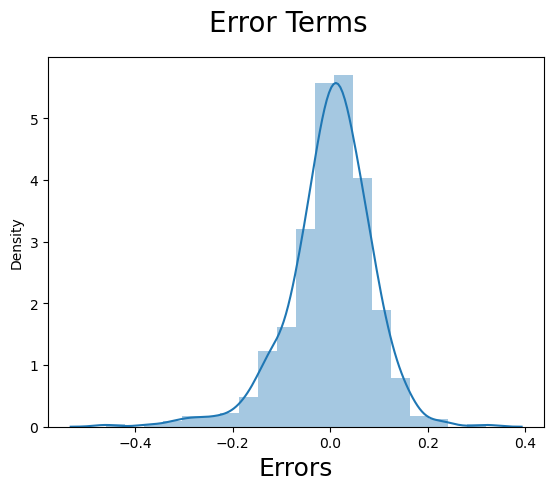

In [39]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

The distplot indicates that the residuals are normally distributed.

In [40]:
#X_test[num_vars] = scaler.transform(X_test[num_vars])

In [41]:
X_test[num_vars_new] = scaler.transform(X_test[num_vars_new])
y_test = X_test['cnt']
X_test.drop(['cnt'],axis=1,inplace=True)

In [42]:
# Now let's use our model to make predictions.
df_temp = X_train_sm_final.drop('const',axis=1,inplace=False)


In [43]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[df_temp.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

### Making predictions

In [44]:

y_pred = model_final.predict(X_test_new)

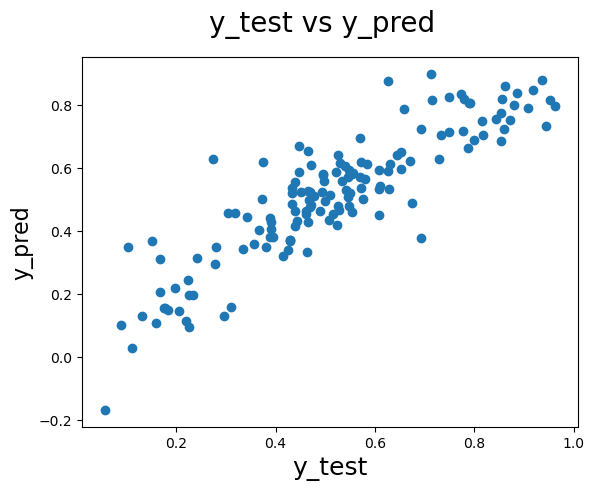

In [45]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)  
plt.show()

In [46]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7758619280027723

R2 score is 0.77 which means a 77% variance explained by the independent variable

In [47]:
df_results = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

#Calculating Residuals
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
print('Residual Calculation')
print(df_results.head())
print('\n')

Residual Calculation
       Actual  Predicted  Residuals
184  0.692706   0.376163   0.316543
535  0.712034   0.898434  -0.186400
299  0.303382   0.455845  -0.152462
221  0.547400   0.594808  -0.047409
152  0.569029   0.569500  -0.000471




In [48]:
#Plotting actual vs predicted

sns.pairplot(df_results, x_vars='Actual', y_vars='Predicted',kind='reg', size=6)

There is a linear relationship between actual and predicted.

In [49]:
from statsmodels.stats.stattools import durbin_watson 

d = durbin_watson(df_results['Residuals'])
d

1.8884408280388516

In [50]:
if d < 1.5 :
    print("Signs of positive correlation")
elif d > 2.5:
    print("Signs of negative correlation")
else:
    print("No autocorrelation")

No autocorrelation


In [51]:
### Homoscedasticity validation

In [52]:
sns.pairplot(df_results, x_vars=['Predicted'], y_vars=['Residuals'], size=6)

No pattern evident which indicates Homoscedasticity